In [1]:
%pylab inline
!pip install pyproj --quiet
!pip install scipy --quiet
!pip install Basemap --quiet
!pip install satpy --quiet

Populating the interactive namespace from numpy and matplotlib
     |████████████████████████████████| 6.3 MB 4.7 MB/s 
     |████████████████████████████████| 863 kB 5.4 MB/s 
     |████████████████████████████████| 219 kB 56.4 MB/s 
     |████████████████████████████████| 30.5 MB 46.1 MB/s 
     |████████████████████████████████| 1.2 MB 5.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 44 kB 2.3 MB/s 
     |████████████████████████████████| 212 kB 12.2 MB/s 
     |████████████████████████████████| 153 kB 47.6 MB/s 
     |████████████████████████████████| 3.4 MB 40.5 MB/s 
     |████████████████████████████████| 69 kB 5.9 MB/s 
     |████████████████████████████████| 6.2 MB 38.2 MB/s 


In [2]:
# data files at xin's google shared folder https://drive.google.com/drive/u/5/folders/10p0MOdTef1IuZORTLuPQrq3DzsRwtwsF 
from google.colab import drive
drive.mount('content/')

Mounted at content/


In [27]:
def bytescale(data, cmin=None, cmax=None, high=255, low=0):
    """
    Byte scales an array (image).
    Byte scaling means converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.
    This function is only available if Python Imaging Library (PIL) is installed.
    Parameters
    ----------
    data : ndarray
        PIL image data array.
    cmin : scalar, optional
        Bias scaling of small values. Default is ``data.min()``.
    cmax : scalar, optional
        Bias scaling of large values. Default is ``data.max()``.
    high : scalar, optional
        Scale max value to `high`.  Default is 255.
    low : scalar, optional
        Scale min value to `low`.  Default is 0.
    Returns
    -------
    img_array : uint8 ndarray
        The byte-scaled array.
    Examples
    --------
    >>> from scipy.misc import bytescale
    >>> img = np.array([[ 91.06794177,   3.39058326,  84.4221549 ],
    ...                 [ 73.88003259,  80.91433048,   4.88878881],
    ...                 [ 51.53875334,  34.45808177,  27.5873488 ]])
    >>> bytescale(img)
    array([[255,   0, 236],
           [205, 225,   4],
           [140,  90,  70]], dtype=uint8)
    >>> bytescale(img, high=200, low=100)
    array([[200, 100, 192],
           [180, 188, 102],
           [155, 135, 128]], dtype=uint8)
    >>> bytescale(img, cmin=0, cmax=255)
    array([[91,  3, 84],
           [74, 81,  5],
           [52, 34, 28]], dtype=uint8)
    """
    if data.dtype == np.uint8:
        return data

    if high > 255:
        raise ValueError("`high` should be less than or equal to 255.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint8)

In [28]:
import h5py
#from scipy.misc import bytescale
from mpl_toolkits.basemap import Basemap
from scipy import interpolate
from scipy.interpolate import griddata
from matplotlib import colors

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pprint
from netCDF4 import Dataset 

#viirs file /content/content/My Drive/Colab Notebooks/chenxi/Data/VIIRS/
# v03_file = '/content/drive/MyDrive/Chenxi_Shared_Research/Data/VIIRS/VNP03MOD.A2014187.0200.001.2017255041028.nc'
# v02_file = '/content/drive/MyDrive/Chenxi_Shared_Research/Data/VIIRS/VNP02MOD.A2014187.0200.001.2017255042300.nc'
v03_file = '/content/content/My Drive/Colab Notebooks/chenxi/Data/VIIRS/VNP03MOD.A2014187.0200.001.2017255041028.nc'
v02_file = '/content/content/My Drive/Colab Notebooks/chenxi/Data/VIIRS/VNP02MOD.A2014187.0200.001.2017255042300.nc'
#cloud property file
# cldprop_file = '/content/drive/MyDrive/Chenxi_Shared_Research/Data/VIIRS/CLDPROP_L2_VIIRS_SNPP.A2014187.0200.011.2019229110444.nc'
cldprop_file = '/content/content/My Drive/Colab Notebooks/chenxi/Data/VIIRS/CLDPROP_L2_VIIRS_SNPP.A2014187.0200.011.2019229110444.nc'

#xin's
# xin_file = '/content/drive/MyDrive/Chenxi_Shared_Research/Data/VIIRS/VNP032014187.0200_prediction_new.nc'
# xin_file = '/content/content/My Drive/Colab Notebooks/chenxi/Data/VIIRS/VNP032014187.0200_prediction_onlyM16_samplesdata.nc'
xin_file = '/content/content/My Drive/Colab Notebooks/chenxi/Data/VIIRS/VNP032014187.0200_prediction_onlyM16_1stmonth.nc'


Read V02 and V03

In [29]:
v03 = Dataset(v03_file,'r')
v03_lon = v03['/geolocation_data/longitude'][:]
v03_lat = v03['/geolocation_data/latitude'][:]
v03_sza = v03['/geolocation_data/solar_zenith'][:]
v03_vza = v03['/geolocation_data/sensor_zenith'][:]
v03_saa = v03['/geolocation_data/solar_azimuth'][:]
v03_vaa = v03['/geolocation_data/sensor_azimuth'][:]
v03.close()

v02 = Dataset(v02_file,'r')
r_data = v02['/observation_data/M05'][:]
g_data = v02['/observation_data/M04'][:]
b_data = v02['/observation_data/M02'][:]
v02.close()

cldprop = Dataset(cldprop_file,'r')
opphase = cldprop['/geophysical_data/Cloud_Phase_Optical_Properties'][:]
ctphase = cldprop['/geophysical_data/Cloud_Phase_Cloud_Top_Properties'][:]
cldprop.close()

xin = Dataset(xin_file,'r')
xinphase = xin['prediction'][:]
xin.close()

Define RGB

In [30]:
along_track = v03_lon.shape[0]
cross_track = v03_lon.shape[1]

z = np.zeros((along_track, cross_track,3))
z[:,:,0] = r_data
z[:,:,1] = g_data
z[:,:,2] = b_data
z[ z > 1 ] = 1.0
z[ z < 0 ] = 0.0

In [31]:
#----------------------------------------------------------------------------------------#
# Color enhancement

x = np.array([0,  30,  60, 120, 190, 255], dtype=np.uint8)
y = np.array([0, 110, 160, 210, 240, 255], dtype=np.uint8)

def scale_image(image, x, y):
    scaled = np.zeros((along_track, cross_track), dtype=np.uint8)
    for i in range(len(x)-1):
        x1 = x[i]
        x2 = x[i+1]
        y1 = y[i]
        y2 = y[i+1]
        m = (y2 - y1) / float(x2 - x1)
        b = y2 - (m *x2)
        mask = ((image >= x1) & (image < x2))
        scaled = scaled + mask * np.asarray(m * image + b, dtype=np.uint8)

    mask = image >= x2
    scaled = scaled + (mask * 255)

    return scaled

In [32]:
z_color_enh = np.zeros((along_track, cross_track,3), dtype=np.uint8)
z_color_enh[:,:,0] = scale_image(bytescale(z[:,:,0]), x, y)
z_color_enh[:,:,1] = scale_image(bytescale(z[:,:,1]), x, y)
z_color_enh[:,:,2] = scale_image(bytescale(z[:,:,2]), x, y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


Text(0.5, 1.0, 'Predicted Phase')

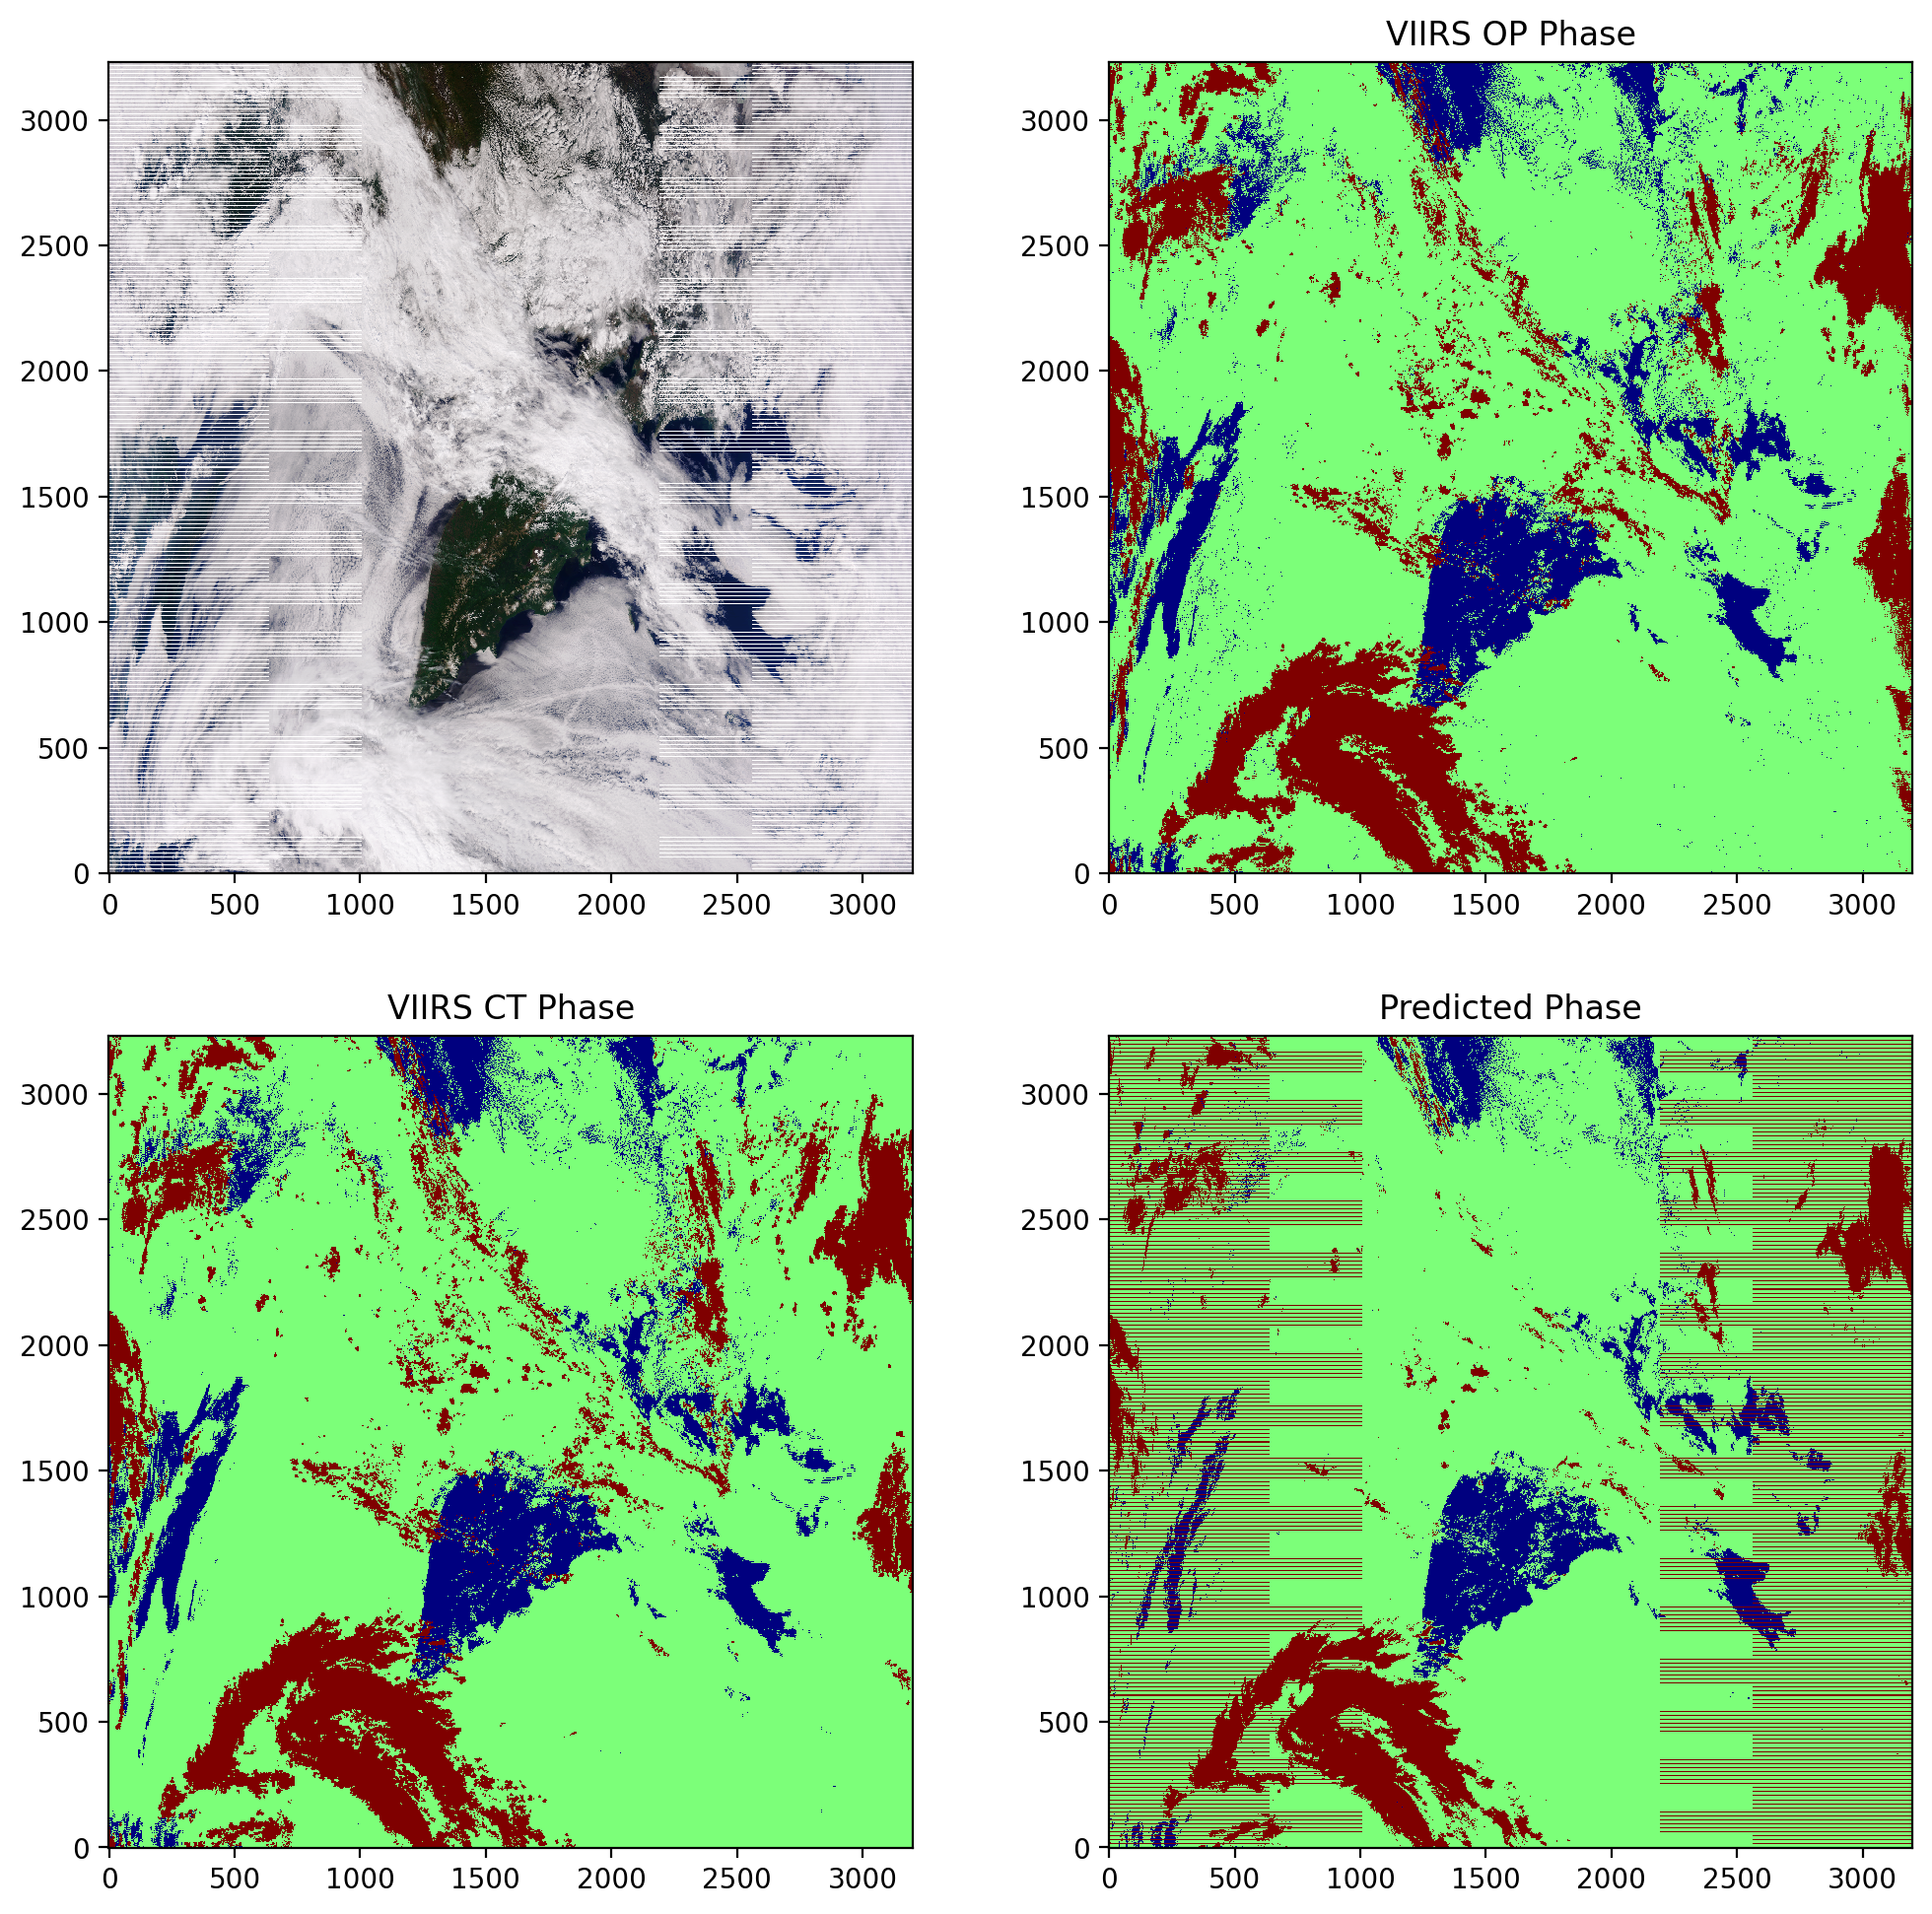

In [33]:
#----------------------------------------------------------------------------------------#
# plot image using matplotlib

fig = plt.figure(figsize=(12, 12), dpi=200)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

img = ax1.imshow(np.fliplr(z_color_enh), interpolation='nearest', origin='lower')

ticks_x_pos = [0,500,1000,1500,2000,2500,3000]
ticks_x_label = ['0','500','1000', '1500', '2000','2500','3000']
ticks_y_pos = [0,500,1000,1500,2000,2500,3000]
ticks_y_label = ['0','500','1000', '1500', '2000','2500','3000']

ax1.set_xticks(ticks_x_pos, ticks_x_label)
ax1.set_yticks(ticks_y_pos, ticks_y_label)

opphase_plot = np.zeros([along_track,cross_track],dtype=np.int8)
ctphase_plot = np.zeros([along_track,cross_track],dtype=np.int8)
xinphase_plot= np.zeros([along_track,cross_track],dtype=np.int8)

opphase_plot[opphase==0] = 0
opphase_plot[opphase==1] = 1
opphase_plot[opphase==2] = 2
opphase_plot[opphase>2] = 3

ctphase_plot[ctphase==0] = 1
ctphase_plot[ctphase==1] = 2
ctphase_plot[ctphase==2] = 3

xinphase_plot[xinphase==0] = 1
xinphase_plot[xinphase==1] = 2
xinphase_plot[xinphase==2] = 3

img = ax2.imshow(np.fliplr(bytescale(opphase_plot, cmin=0, cmax=3, high=255, low=0)), interpolation='nearest', origin='lower', cmap='jet')
img = ax3.imshow(np.fliplr(bytescale(ctphase_plot, cmin=0, cmax=3, high=255, low=0)), interpolation='nearest', origin='lower', cmap='jet')
img = ax4.imshow(np.fliplr(bytescale(xinphase_plot, cmin=0, cmax=3, high=255, low=0)), interpolation='nearest', origin='lower', cmap='jet')

ax2.set_title('VIIRS OP Phase')
ax3.set_title('VIIRS CT Phase')
ax4.set_title('Predicted Phase')

#plt.title('MODIS RGB Image', fontsize=10)

#plt.savefig("modis_granule_rgb_color_enh.png", bbox_inches='tight', dpi=200)

#plt.show()

#plt.close()

In [18]:
a = bytescale(opphase, cmin=1, cmax=4, high=255, low=0)

In [19]:
opphase[100:102,100:102]

masked_array(
  data=[[2, 2],
        [2, 2]],
  mask=False,
  fill_value=999999,
  dtype=int8)

In [20]:
op = np.arange(6)
a = bytescale(op, cmin=1, cmax=4, high=255, low=0)
ct = np.arange(3)
b = bytescale(ct, cmin=0, cmax=3, high=255, low=0)

In [ ]:
print (op,a)

[0 1 2 3 4 5] [  0   0  85 170 255 255]


In [ ]:
print (ct,b)

[0 1 2] [  0  85 170]


In [ ]:
np.max(ctphase)

2

In [ ]:
xinphase.shape

(3232, 3200)